In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [2]:
sns.set_context('talk')

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [5]:
dfXtrain = pd.read_csv('preprocessed_csv/train_tree.csv', index_col='id', sep=';')
dfXtest = pd.read_csv('preprocessed_csv/test_tree.csv', index_col='id', sep=';')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_tree.csv', header=None, names=['ID', 'COTIS'], sep=';')

In [6]:
dfYtrain = dfYtrain.set_index('ID')

# Preprocessing

Вынесем var14, department и subreg.

In [7]:
dropped_col_names = ['var14', 'department', 'subreg'] 

def drop_cols(df):
    return df.drop(dropped_col_names, axis=1), df[dropped_col_names]

In [8]:
train, dropped_train = drop_cols(dfXtrain)
test, dropped_test = drop_cols(dfXtest)

Добавим инфу о величине города из subreg'a

In [9]:
def add_big_city_cols(df, dropped_df):
    df['big'] = np.where(dropped_df['subreg'] % 100 == 0, 1, 0)
    df['average'] = np.where(dropped_df['subreg'] % 10 == 0, 1, 0)
    df['average'] = df['average'] - df['big']
    df['small'] = 1 - df['big'] - df['average']
    return df

In [10]:
train = add_big_city_cols(train, dropped_train)
test = add_big_city_cols(test, dropped_test)

Декодируем оставшиеся категориальные признаки

In [11]:
categorical = list(train.select_dtypes(exclude=[np.number]).columns)
categorical

['marque', 'energie_veh', 'profession', 'var6', 'var8']

In [12]:
list(test.select_dtypes(exclude=[np.number]).columns)

['marque', 'energie_veh', 'profession', 'var6', 'var8']

In [13]:
for col in categorical:
    print(col, train[col].nunique())

marque 154
energie_veh 5
profession 17
var6 5
var8 23


energie_veh и var6 с помощью get_dummies

In [14]:
small_cat = ['energie_veh', 'var6']

In [15]:
train = pd.get_dummies(train, columns=small_cat)
test = pd.get_dummies(test, columns=small_cat)

Для остальных посчитаем сглаженные средние таргета

In [16]:
big_cat = ['marque', 'profession', 'var8']

Описание для начала

In [17]:
df = pd.concat([dfYtrain.describe()] + [train[col].value_counts().describe() for col in big_cat], axis=1)
df

,COTIS,marque,profession,var8
count,300000.000000,154.000000,17.000000,23.000000
mean,346.063566,1946.168831,17647.058824,13018.000000
std,119.870510,8040.202889,29867.244501,24502.085807
min,94.780000,1.000000,393.000000,1.000000
25%,262.050000,3.000000,2610.000000,775.000000
50%,323.220000,11.500000,5829.000000,2208.000000
75%,407.500000,359.750000,13273.000000,7045.000000
max,1518.810000,73371.000000,110354.000000,91826.000000


Сглаживать будем с 500

Будем использовать среднее, 25%, 50% и 75%

Декодирование

In [18]:
class EncodeWithAggregates():

    def __init__(self, cols, y_train, train, *tests, smooth_coef=None):
        self.cols = cols
        self.y_train = y_train
        self.train = train
        self.tests = tests
        self.Xs = (self.train,) + self.tests
        
        self.miss_val = 'NAN'
        self.percentiles = [25, 50, 75]
        self.names = ['Mean'] + [str(q) for q in self.percentiles]
        self.aggs = [np.mean] + [self.percentile_fix(q) for q in self.percentiles]
        self.miss_val_fills = [agg(y_train) for agg in self.aggs]
        self.train_aggs = [agg(y_train) for agg in self.aggs]
        if smooth_coef:
            self.smooth_coef = smooth_coef
        else:
            self.smooth_coef = {col: 0 for col in cols}
        

    def percentile_fix(self, q):
        def wrapped(a):
            return np.percentile(a, q)

        return wrapped
        
    
    def transform(self):
        for col in self.cols:
            self.encode(col)
            gc.collect()
        return self.Xs
    
    
    def encode(self, col):
        df = pd.concat([self.y_train, self.train[col]], axis=1)
        dfgb = df.groupby(col)
        dfsize = dfgb.size()
        dfsize.ix[self.miss_val] = 0

        for X in self.Xs:                
            agg_size = dfsize.ix[X[col].fillna(self.miss_val)]
            agg_size = pd.DataFrame({'size': agg_size}).set_index(X.index)['size']
            agg_name = "{}_{}".format(col, 'size')
            X[agg_name] = agg_size

        for name, agg, miss_val_fill, train_agg in zip(self.names, self.aggs, self.miss_val_fills, self.train_aggs):
            dfm = dfgb.agg(agg)
            dfm.ix[self.miss_val] = miss_val_fill
            for X in self.Xs:                
                agg_df = dfm.ix[X[col].fillna(self.miss_val)].set_index(X.index)[self.y_train.name]
                agg_size = dfsize.ix[X[col].fillna(self.miss_val)]
                agg_size = pd.DataFrame({'size': agg_size}).set_index(X.index)['size']
                agg_name = "{}_{}".format(col, name)
                X[agg_name] = (agg_df * agg_size + self.smooth_coef[col] * train_agg) / (self.smooth_coef[col] + agg_size)
        
        self.Xs = [X.drop(col, axis=1) for X in self.Xs]

In [19]:
smooth_coef = {'profession': 0, 'var8': 500, 'marque': 500}

train, test = EncodeWithAggregates(big_cat, dfYtrain['COTIS'], train, test, smooth_coef=smooth_coef).transform()

In [20]:
test.shape

(30000, 54)

In [21]:
train.shape

(300000, 54)

In [22]:
train.fillna(-9999, inplace=True)
test.fillna(-9999, inplace=True)

In [23]:
low_importance_features = ['var1', 'var12', 'var8_75', 'average', 'big', 'energie_veh_gpl', 
                           'var8_50', 'small', 'energie_veh_hybride essence', 'energie_veh_electricite']

In [24]:
train = train.drop(low_importance_features, axis=1)
test = test.drop(low_importance_features, axis=1)

In [25]:
low_importance_features = ['var6_N', 'var21']

In [26]:
train = train.drop(low_importance_features, axis=1)
test = test.drop(low_importance_features, axis=1)

In [27]:
low_importance_features = ['profession_50', 'var6_D', 'profession_25']

In [28]:
train = train.drop(low_importance_features, axis=1)
test = test.drop(low_importance_features, axis=1)

In [29]:
train.shape

(300000, 39)

In [30]:
test.shape

(30000, 39)

In [31]:
y_train = np.array(dfYtrain)
x_train = np.array(train)
x_test = np.array(test)

# Save routines

In [32]:
dfYtest = pd.DataFrame({'ID': dfXtest.index, 'COTIS': np.zeros(test.shape[0])})
dfYtest = dfYtest[['ID', 'COTIS']]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [33]:
def save_to_file(y, file_name):
    dfYtest['COTIS'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

In [35]:
model_name = 'lmse_with_size'
dfYtest_stacking = pd.DataFrame({'ID': dfXtrain.index, model_name: np.zeros(train.shape[0])})
dfYtest_stacking = dfYtest_stacking[['ID', model_name]]
dfYtest_stacking.head()

,ID,lmse_with_size
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [36]:
def save_to_file_stacking(y, file_name):
    dfYtest_stacking[model_name] = y
    dfYtest_stacking.to_csv('stacking/{}'.format(file_name), index=False, sep=';')

# Train XGB

In [37]:
import xgboost as xgb
XGBR = xgb.XGBRegressor
from sklearn.cross_validation import LabelKFold
from sklearn.grid_search import GridSearchCV

In [38]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(10, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [39]:
def mape(y_true, y_pred): 
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
def mape_scorer(est, X, y):
    gc.collect()
    return mape(y, est.predict(X))

In [41]:
class MyGS():
    class Element():
        def __init__(self):
            self.cv_validation_scores = []
        
        
        def add(self, score):
            self.cv_validation_scores.append(score)
    
    
    def __init__(self, param_grid, name, n_folds):
        self.param_grid = {name: param_grid}
        self.grid_scores_ = [MyGS.Element() for item in param_grid]
        
    
    def add(self, score, param_num):
        self.grid_scores_[param_num].add(score)
        

In [42]:
def amse(preds, dtrain, alpha=1, beta=1, gamma=1, divider=1):
    labels = dtrain.get_label()
    labels2 = np.power(labels, 2)
    grad = np.where(preds > labels, 
                    alpha * (preds - labels) / labels2 - gamma, 
                    alpha * (preds - labels) / (labels2 * divider) + gamma)
    second_grad = beta * np.where(preds > labels, 1, 1 / divider) / labels2
    return grad, second_grad

In [43]:
def amse_fixed(alpha, beta, gamma, divider):
    def wrapper(*args, **kwargs):
        return amse(*args, alpha=alpha, beta=beta, gamma=gamma, divider=divider, **kwargs)
    return wrapper

Вот клетка с оптимальными настройками

In [44]:
%%time

param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
           'eta':0.15, 'max_delta_step':0, 'max_depth':9,
           'min_child_weight':1, 'nthread':-1,
           'objective':'reg:linear', 'alpha':0, 'lambda':1,
           'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

diff_num_round_list = [40 for i in range(7)]
diff_num_round_list[0] = 60
num_round_list = np.cumsum(diff_num_round_list)
n_folds = 3
obj=None
weight_coef = 1000
y_log = np.log(y_train)

mygs = MyGS(num_round_list, 'num_round', n_folds=n_folds)

label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)

for train_index, test_index in tqdm_notebook(label_kfold, desc='fold'):
    dtrain = xgb.DMatrix(x_train[train_index], 
                         label=y_log[train_index], 
                         missing=-9999,) 
                         #weight=weight_coef * np.power(y_train[train_index], -2) )
    dvalidation = xgb.DMatrix(x_train[test_index], missing=-9999)
    y_validation = y_train[test_index][:, 0]
    param['base_score'] = np.percentile(y_log[train_index], 25)
    bst = None
    for index, diff_num_round in enumerate(diff_num_round_list):
        bst = xgb.train(param, dtrain, diff_num_round, obj=obj, xgb_model=bst)
        y_pred = np.exp(bst.predict(dvalidation))
        score = mape(y_validation, y_pred)
        mygs.add(score, index)
    gc.collect()


CPU times: user 14min 51s, sys: 652 ms, total: 14min 52s
Wall time: 14min 54s


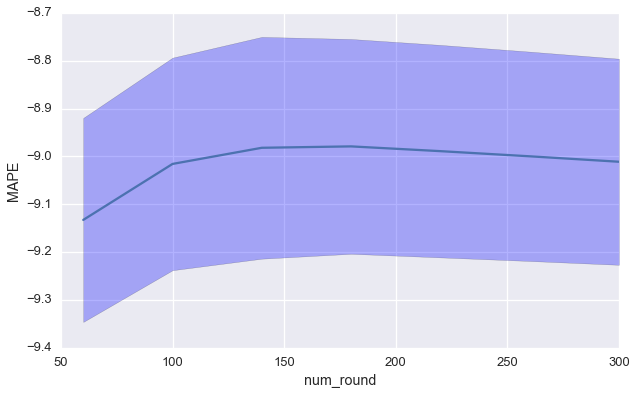

In [45]:
plot_quality(mygs, 'num_round')

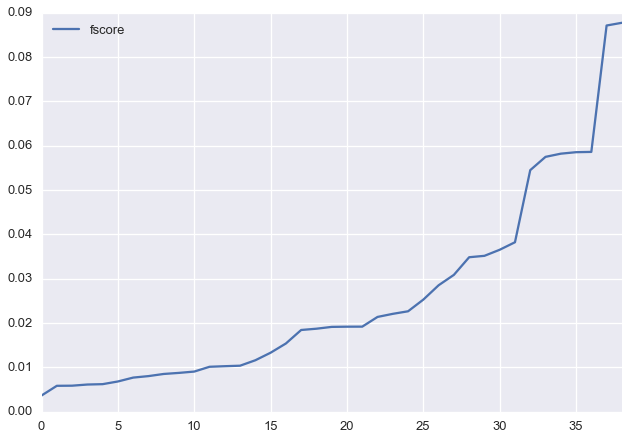

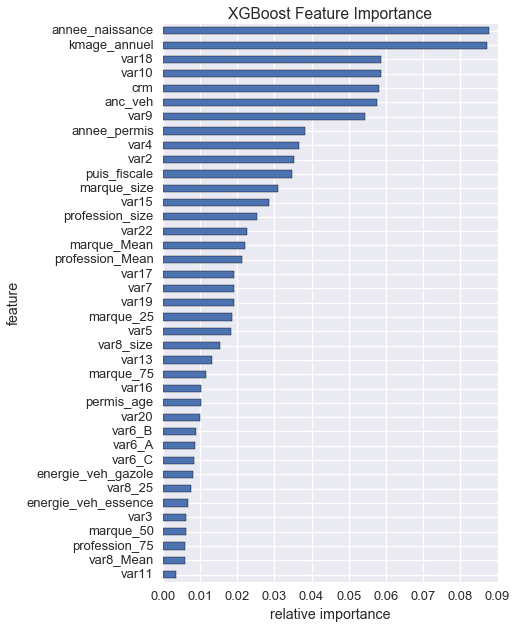

In [46]:
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df['feature'] = df['feature'].apply(lambda x: train.columns[int(str(x)[1:])])

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [47]:
%%time

param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
           'eta':0.15, 'max_delta_step':0, 'max_depth':9,
           'min_child_weight':1, 'nthread':-1,
           'objective':'reg:linear', 'alpha':0, 'lambda':1,
           'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

num_round = 180
n_folds = 5

y_pred = np.array(dfYtrain) #like a copy of y_train

label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)

for train_index, test_index in tqdm_notebook(label_kfold, desc='fold'):
    dtrain = xgb.DMatrix(x_train[train_index], 
                         label=np.log(y_train[train_index]), 
                         missing=-9999,) 
                         #weight=weight_coef * np.power(y_train[train_index], -2) )
    dvalidation = xgb.DMatrix(x_train[test_index], missing=-9999)
    param['base_score'] = np.percentile(np.log(y_train[train_index]), 25)
    bst = xgb.train(param, dtrain, num_round)
    y_pred[test_index, 0] = np.exp(bst.predict(dvalidation))
    gc.collect()


CPU times: user 17min 23s, sys: 1.3 s, total: 17min 25s
Wall time: 17min 28s


In [48]:
y_lmse_pred = y_pred[:, :]

In [49]:
onex = y_lmse_pred[:, 0].reshape((y_lmse_pred.shape[0], 1))

In [50]:
%%time

n_folds = 10
label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)
weight_list = [w for w in np.arange(0.8, 1.2, 0.005)
               ]
scores = [-100 for i in range(n_folds)]
train_scores = [-100 for i in range(n_folds)]
weights = [0 for i in range(n_folds)]

for fold_index, (train_index, test_index) in enumerate(label_kfold):
    X = onex[train_index]
    y = y_train[train_index][:, 0]
    X_validation = onex[test_index]
    y_validation = y_train[test_index][:, 0]
    good_score = -np.Inf
    good_weight = None
    for weight in weight_list:
        y_pred = X[:, 0] * weight
        score = mape(y, y_pred)
        if score > good_score:
            good_score = score
            good_weight = weight
    y_pred = X_validation[:, 0] * good_weight
    scores[fold_index] = mape(y_validation, y_pred)
    train_scores[fold_index] = good_score
    weights[fold_index] = good_weight   

CPU times: user 2.89 s, sys: 0 ns, total: 2.89 s
Wall time: 2.89 s


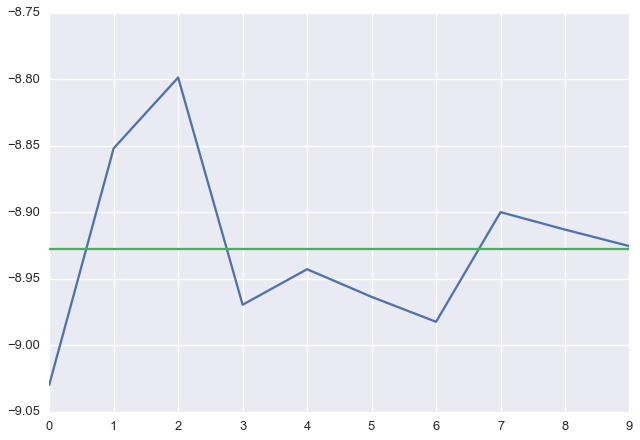

In [51]:
plt.plot(train_scores)
mean = np.mean(train_scores)
plt.plot([mean for i in train_scores])

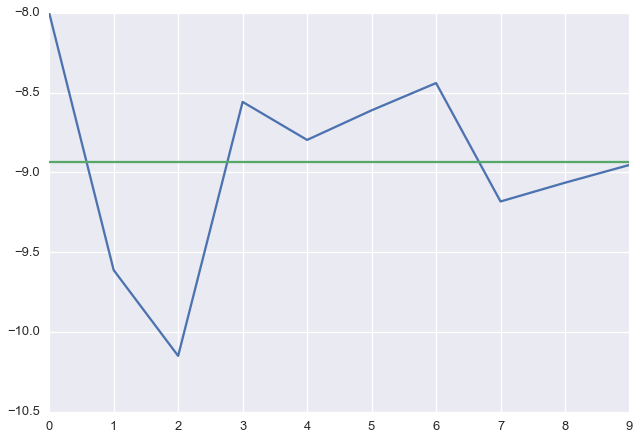

In [52]:
plt.plot(scores)
mean = np.mean(scores)
plt.plot([mean for i in scores])

In [53]:
weights

[0.99500000000000022,
 0.99500000000000022,
 0.99000000000000021,
 0.99500000000000022,
 0.99500000000000022,
 0.99500000000000022,
 0.99500000000000022,
 0.99500000000000022,
 0.99500000000000022,
 0.99500000000000022]

In [54]:
mean

-8.9373085016444218

# Save

In [55]:
save_to_file_stacking(y_lmse_pred * 0.995, 'xbg_tune_eta015_num300_with_size_dropped_lmse.csv')

In [ ]:
%%time

param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
           'eta':0.15, 'max_delta_step':0, 'max_depth':9,
           'min_child_weight':1, 'nthread':-1,
           'objective':'reg:linear', 'alpha':0, 'lambda':1,
           'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

num_round = 180

dtrain = xgb.DMatrix(x_train, 
                     label=np.log(y_train), 
                     missing=-9999,) 
                     #weight=weight_coef * np.power(y_train[train_index], -2) )
dtest = xgb.DMatrix(x_test, missing=-9999)
param['base_score'] = np.percentile(np.log(y_train), 25)
bst = xgb.train(param, dtrain, num_round)
y_pred = np.exp(bst.predict(dtest))
gc.collect()

In [ ]:
save_to_file(y_pred * 0.995, 'xbg_tune_eta015_num300_with_size_dropped_lmse.csv')